# Visualize AMASS dataset

In [1]:
%cd ../

c:\Users\User\Desktop\work\Partial2FullBodyMotion


In [2]:
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt

In [3]:
# Load Configs
config = json.load(open("config.json")) 
ds_config = config['dataset']

## Load Datasets

In [4]:
import dataset

# Load and Create AMASS DS object
amass = dataset.AMASS(
	ds_config['amass_path'], 
	whitelist=['MPI_Limits'], 
	model_path=ds_config['model_filepath'],
	framerate_adjust=ds_config['framerate_adjust'] # to adjust framerate for sequence
	)

# make ds small for visualize purpose
amass.ds = amass.ds[:1]
amass.ds[0] = amass.ds[0].take(5)

ds = amass.get_fullbody()

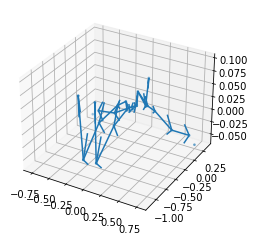

In [29]:
# Visualize default T pose
ax = plt.figure(figsize=plt.figaspect(1)).add_subplot(projection="3d")
ax.quiver3D(*model['J'][model['kintree_table'][0,1:22]].T, *(model['J'][1:22]-model['J'][model['kintree_table'][0,1:22]]).T)
ax.scatter3D(*model['J'].T, s=3)
plt.show()

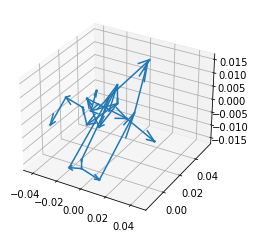

In [30]:
model = np.load(ds_config['model_filepath'])

a, b = ds.as_numpy_iterator().next()
b = dataset.apply_trans(b, model['kintree_table']).numpy()[:, :3, 3]

ax = plt.figure(figsize=plt.figaspect(1)).add_subplot(projection="3d")
ax.quiver3D(*b[model['kintree_table'][0,1:22]].T, *(b[1:]-b[model['kintree_table'][0,1:22]]).T)
ax.scatter3D(*b.T, s=3)
plt.show()

Looks like something's gone wrong
probably:
- the order of matmul
- representation of rotation (from left or right)
- 